## Датасет

Первое, что пришло в голову это детектировать какие-то объекты, связанные с движением на дорогах. Самым популярным датасетом, в котором собраны изображения автомобилей:
https://www.kaggle.com/datasets/sshikamaru/car-object-detection

Содержит 1001 тренировочное изображение и 175 тестовых.


In [1]:
! pip install ultralytics --quiet
! pip install pycocotools

import pycocotools
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import yaml
import torch
import shutil
import torch
import time
import random
from tqdm import tqdm
from PIL import Image
from skimage.feature import hog
from skimage.transform import pyramid_gaussian
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, precision_score, recall_score
from IPython.display import clear_output
import joblib
from joblib import Parallel, delayed
from torchvision.transforms import functional as F
import zipfile
import matplotlib.image as mpimg

from scipy.interpolate import interp1d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 27.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# YOLO

In [2]:
! kaggle datasets download -d "sshikamaru/car-object-detection"
# Распакуем архив
with zipfile.ZipFile("car-object-detection.zip", 'r') as zip_ref:
  zip_ref.extractall("car-object-detection")

Dataset URL: https://www.kaggle.com/datasets/sshikamaru/car-object-detection
License(s): other
 99% 111M/112M [00:06<00:00, 24.0MB/s]
100% 112M/112M [00:06<00:00, 17.5MB/s]


In [3]:
# про объем датасета
print(f'Объем тренировочного датасета: {len(os.listdir("car-object-detection/data/training_images"))}')
df = pd.read_csv('car-object-detection/data/train_solution_bounding_boxes (1).csv')
df['class'] = 0  # Все объекты это машины - класс 0
# есть столбец image, переименую в image_path
# df = df.rename(columns={'image': 'image_path'})
print(f'Из них на {len(df)} есть автомобили.\n')
print(f'Объем тестового датасета: {len(os.listdir("car-object-detection/data/testing_images"))}')
df.head()

Объем тренировочного датасета: 1001
Из них на 559 есть автомобили.

Объем тестового датасета: 175


,image,xmin,ymin,xmax,ymax,class
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547,0
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180,0
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180,0
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575,0
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422,0


Видно, что требуется нормализовать данные. Сделаем

In [4]:
'''нормализация координат рамки'''
def normalizer(row, img_width, img_height):
    x_centre = (row["xmin"] + row["xmax"]) / (2 * img_width)
    y_centre = (row["ymin"] + row["ymax"]) / (2 * img_height)
    width = (row["xmax"] - row["xmin"]) / img_width
    height = (row["ymax"] - row["ymin"]) / img_height
    return x_centre, y_centre, width, height


'''Пробег по изображениям'''
for idx, row in df.iterrows():
    img_path = os.path.join('car-object-detection/data/training_images', row['image'])

    # вдруг нет такой картинки, пропустим
    if not os.path.exists(img_path):
        continue

    img = Image.open(img_path)
    img_width, img_height = img.size

    df.loc[idx, ['x_centre', 'y_centre', 'width', 'height']] = normalizer(row, img_width, img_height)

df[['x_centre', 'y_centre', 'width', 'height']] = df[['x_centre', 'y_centre', 'width', 'height']].clip(0, 1)
# оставим только нужные столбцы
df = df[['image', 'class', 'x_centre', 'y_centre', 'width', 'height']].rename(columns={'image': 'image_path'})
df.head()

,image_path,class,x_centre,y_centre,width,height
0,vid_4_1000.jpg,0,0.450434,0.539817,0.068741,0.095238
1,vid_4_10000.jpg,0,0.100217,0.557191,0.155572,0.129987
2,vid_4_10040.jpg,0,0.444645,0.543678,0.181621,0.157014
3,vid_4_10020.jpg,0,0.833213,0.531451,0.197540,0.155727
4,vid_4_10060.jpg,0,0.110347,0.559122,0.171491,0.136422


## Деление train/val (80% на 20%)
Также метки приводим к виду: class_id, center_x, center_y, width, height через пробел

In [5]:
'''train-val split'''
train_idxs = random.sample(range(len(df)), int(0.8*len(df)))
val_idxs = set(range(len(df))) - set(train_idxs)

'''Создание директорий, где финальный датасет будет лежать'''
root_dir= 'dataset'
labels_dir= 'dataset/labels'
images_dir= 'dataset/images'

os.makedirs(root_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)
os.makedirs(images_dir, exist_ok=True)

os.makedirs(os.path.join(images_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(images_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(labels_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(labels_dir, 'val'), exist_ok=True)


'''Растасовка картинок по папкам'''
for idx, img_name in enumerate(list(df['image_path'])):
    subset = 'train' if idx in train_idxs else 'val'

    if np.isin(img_name, df['image_path']):
        columns=['class', 'x_centre', 'y_centre', 'width', 'height']
        img_bbox=df[df["image_path"] == img_name][columns].values

        label_file_path=os.path.join(labels_dir, subset, img_name[:-4] + ".txt")
        with open(label_file_path, "w+") as f:
            for row in img_bbox:
                text=" ".join(row.astype(str))
                f.write(text)
                f.write("\n")

    old_image_path=os.path.join('car-object-detection/data/training_images', img_name)
    new_image_path=os.path.join(images_dir, subset, img_name)
    shutil.copy(old_image_path, new_image_path)

## Создание YOLO модели и ее обучение

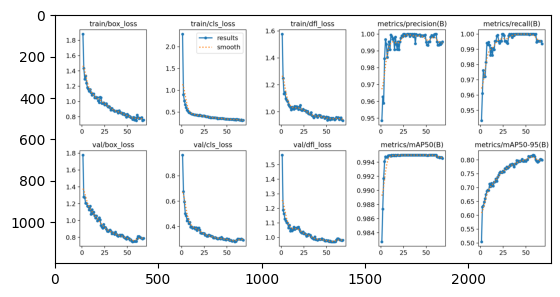

In [6]:
'''Конфигурационный файл модели'''
yolo_format=dict(path='/content/' + root_dir,
                 train='/content/' + os.path.join(images_dir, 'train'),
                 val='/content/' + os.path.join(images_dir, 'val'),
                 nc=1,
                 names={0: "car"})

with open('./yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)

'''Непосредственно обучение'''
model = YOLO('yolov8m.pt')
model.train(data="/content/yolo.yaml",
            epochs=70,
            batch=8,
            patience=10,
            optimizer="SGD",
            lr0=0.001,
            imgsz=640 # по умолчанию
            )
clear_output()

training = mpimg.imread('/content/runs/detect/train/results.png')
plt.imshow(training)

In [7]:
model = YOLO("/content/runs/detect/train/weights/best.pt")
metrics = model.val()
clear_output()

print(f"mAP @ 0.5 = {metrics.box.map50:.4f}")
print(f"mAP @ 0.75 = {metrics.box.map75:.4f}")
print(f"mAP @ 0.5-0.95 = {metrics.box.map:.4f}")

mAP @ 0.5 = 0.9950
mAP @ 0.75 = 0.9754
mAP @ 0.5-0.95 = 0.8170


## Визуализация

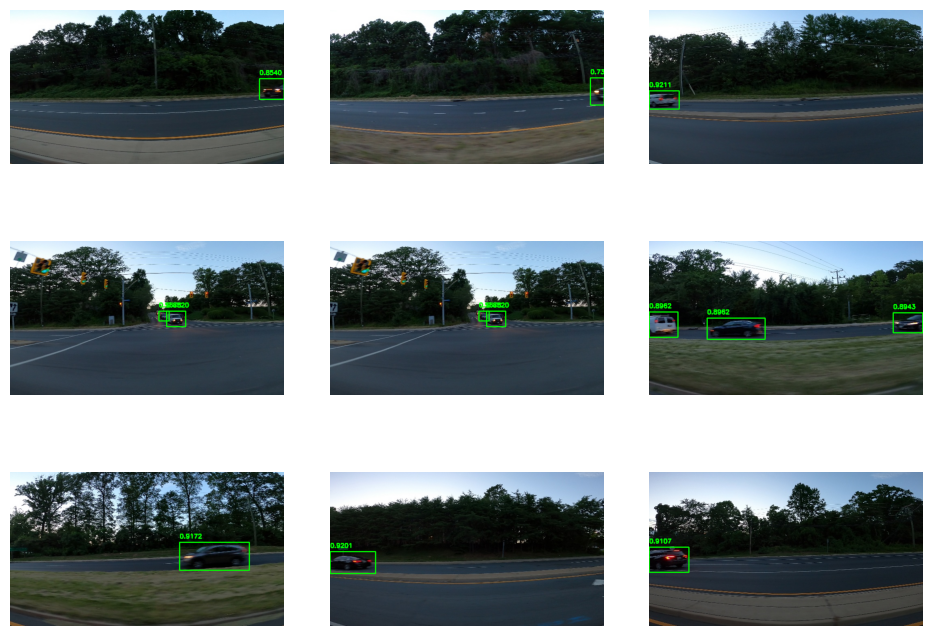

In [8]:
model = YOLO("/content/runs/detect/train/weights/best.pt")
with torch.no_grad():
    results = model.predict(source='car-object-detection/data/testing_images', conf=0.50, iou=0.75, save=True, save_txt=True)
clear_output()

test_img_list=[]
prediction_dir = "/content/predictions"

os.makedirs(prediction_dir, exist_ok=True)

for result in results:
    if len(result.boxes.xyxy):
        name=result.path.split("/")[-1].split(".")[0]
        boxes=result.boxes.xyxy.cpu().numpy()
        scores=result.boxes.conf.cpu().numpy()
        test_img_list.append(name)

        label_file_path = os.path.join(prediction_dir, f"{name}.txt")
        np.savetxt(label_file_path, np.column_stack((scores, boxes)), fmt="%.4f")


def show_bbox(img, boxes, scores, axis, color=(0, 255, 0)):
    for score, box in zip(scores, boxes.astype(int)):
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 2)
        y = box[1] - 10 if box[1] > 20 else box[1] + 10
        cv2.putText(img, f"{score:.4f}", (box[0], y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    axis.imshow(img)
    axis.axis("off")


fig,axes=plt.subplots(3,3,figsize=(12,8))
plt.subplots_adjust(wspace=0.1,hspace=0.5)
ax=axes.flatten()

imgs_name=np.random.choice(test_img_list, 9)

for i,img_name in enumerate(imgs_name):
    img_file_path=os.path.join('car-object-detection/data/testing_images', img_name+".jpg")
    img=cv2.imread(img_file_path)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    label_file_path=os.path.join(prediction_dir, img_name+".txt")
    label=pd.read_csv(label_file_path,sep=" ", header=None).values
    scores=label[:, 0]
    boxes=label[:, 1:]
    show_bbox(img, boxes, scores, axis=ax[i])

## Сканирующее окно с HOG дескриптором

In [9]:
IMG_SIZE = 64

# Paths to images and labels
image_dir = 'car-object-detection/data/training_images'
label_dir = 'car-object-detection/data/train_solution_bounding_boxes (1).csv'

# функция для загрузки картинок + лейблов
def data_preprocessor(image_dir, label_dir, img_size=(IMG_SIZE, IMG_SIZE), max_background_samples=150):
    images, labels, ground_truth_boxes = [], [], []
    # пробегаем по всем данных
    all_train = pd.read_csv('car-object-detection/data/train_solution_bounding_boxes (1).csv')
    for row in list(range(len(all_train))):
      try:
        label_path = os.path.join(label_dir, all_train.iloc[row]['image'])
        image_path = os.path.join(image_dir, all_train.iloc[row]['image'])
        # выгрузка картинки
        image = cv2.imread(image_path)
        h, w, _ = image.shape

        x1, y1, x2, y2 = all_train.iloc[row][['xmin', 'ymin', 'xmax', 'ymax']].values
        x1, x2, y1, y2 = int(x1), int(x2), int(y1), int(y2)

        # обрезка картинки и ее resize
        cropped_obj = image[y1:y2, x1:x2]
        cropped_obj = cv2.resize(cropped_obj, img_size)
        images.append(cropped_obj)
        # класс 1 - есть машина
        labels.append(1)
        # ground_truth_boxes.append([all_train.iloc[row]['image'], (x1, y1, x2, y2)])

        '''Добавление примеров фона'''
        num_background_samples = min(len(labels), max_background_samples)
        for _ in range(num_background_samples):
            x = np.random.randint(0, w - img_size[0])
            y = np.random.randint(0, h - img_size[1])
            background = image[y:y + img_size[1], x:x + img_size[0]]
            images.append(background)
            # класс 0 - это фон, машины нет
            labels.append(0)

      except:
        pass

    return images, labels#, ground_truth_boxes


train_images, train_labels = data_preprocessor(image_dir, label_dir) #, ground_truth_boxes


In [10]:
# train-test split
train_idxs = random.sample(range(len(train_labels)), int(0.95*len(train_labels)))
test_idxs = set(range(len(train_labels))) - set(train_idxs)

train_images2 = [train_images[i] for i in train_idxs]
train_labels2 = [train_labels[i] for i in train_idxs]

test_images2 = [train_images[i] for i in test_idxs]
test_labels2 = [train_labels[i] for i in test_idxs]


## Функция извлечения HOG фичей

In [11]:
def extract_hog_features(images, show_progress=False):
    hog_features = []
    if show_progress:
      for image in tqdm(images):
          fd = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False, channel_axis=-1)
          hog_features.append(fd)

    else:
      for image in images:
          fd = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False, channel_axis=-1)
          hog_features.append(fd)

    return np.array(hog_features)

hog_features = extract_hog_features(train_images2, True)
test_hog_features = extract_hog_features(test_images2, True)

100%|██████████| 4181/4181 [00:11<00:00, 362.38it/s]


In [12]:
svm_classifier = SVC(kernel='linear', probability=True, verbose=True)
svm_classifier.fit(hog_features, train_labels2)

# Evaluate the classifier
y_pred = svm_classifier.predict(test_hog_features)

print("Accuracy:", accuracy_score(test_labels2, y_pred))
print("Precision:", precision_score(test_labels2, y_pred))
print("Recall:", recall_score(test_labels2, y_pred))

[LibSVM]Accuracy: 0.9978474049270509
Precision: 0.9285714285714286
Recall: 0.7878787878787878


Классификатор неплохо различает машины от фона

## Sliding Window

In [13]:
'''Вспомогательные функции'''
def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])


def pyramid(image, scale=1.5, minSize=(IMG_SIZE, IMG_SIZE)):
    yield image
    while True:
        w = int(image.shape[1] / scale)
        image = cv2.resize(image, (w, int(image.shape[0] / scale)))
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image


def detect_objects(image, classifier, window_size=(IMG_SIZE, IMG_SIZE), step_size=int(IMG_SIZE/16), scale=1.5, pred_thresh=0.7):
    detections = []
    for resized in pyramid(image, scale):
        for (x, y, window) in sliding_window(resized, stepSize=step_size, windowSize=window_size):
            if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
                continue
            hog_feature = extract_hog_features([window])
            prediction = classifier.predict(hog_feature)
            veroyat = classifier.predict_proba(hog_feature)[0][1]
            if veroyat >= pred_thresh:
                scale_factor = image.shape[0] / resized.shape[0]
                x1 = int(x * scale_factor)
                y1 = int(y * scale_factor)
                x2 = int((x + window_size[0]) * scale_factor)
                y2 = int((y + window_size[1]) * scale_factor)
                detections.append([(x1, y1, x2, y2), 1, veroyat])
    sorted_detections = sorted(detections, key=lambda x: x)
    return sorted_detections


def non_max_suppression(boxes, overlap_thresh):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    pick = []
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))

    return pick #boxes[pick].astype("int")


def calculate_iou(gt, pred):
    """Вычисляет IoU между двумя bounding boxes."""
    gt_area = (gt[2] - gt[0]) * (gt[3] - gt[1])
    pred_area = (pred[2] - pred[0]) * (pred[3] - pred[1])

    x_min = max(gt[0], pred[0])
    y_min = max(gt[1], pred[1])
    x_max = min(gt[2], pred[2])
    y_max = min(gt[3], pred[3])

    intersection_area = max(0, x_max - x_min) * max(0, y_max - y_min)
    union_area = gt_area + pred_area - intersection_area
    return intersection_area / union_area if union_area > 0 else 0


def calculate_ap(precision, recall):
    precision = np.concatenate([[0], precision, [0]])
    recall = np.concatenate([[0], recall, [1]])

    for i in range(len(precision) - 2, -1, -1):
        precision[i] = max(precision[i], precision[i + 1])

    i = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[i + 1] - recall[i]) * precision[i + 1])
    return ap

def calculate_maps(ground_truths, detections, thresholds=[0.5, 0.75]):
    """Вычисляет mAP@0.5, mAP@0.75 и mAP@0.5:0.95"""

    all_thresholds = thresholds + list(np.arange(0.5, 1.0, 0.05))
    maps = {}
    # print('перебор threshold')
    for threshold in all_thresholds:
        tp = 0
        fp = 0
        fn = len(ground_truths)

        predictions_formatted = [[det[0][0], det[0][1], det[0][2], det[0][3], det[2]] for det in detections]
        sorted_predictions = sorted(predictions_formatted, key=lambda x: x[4], reverse=True)
        # print(f'Для {threshold}')
        # print(sorted_predictions)# [[108, 0, 325, 217, 0.9012628850189565]]

        matched_gts = set()
        for pred in sorted_predictions:
            best_iou = 0
            best_gt_index = -1
            for i, gt in enumerate(ground_truths):
                if i not in matched_gts:
                    iou = calculate_iou(gt, pred[:4])
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_index = i

            # print(best_iou)
            # print(ground_truths)

            if best_iou >= threshold:
                tp += 1
                matched_gts.add(best_gt_index)
                fn -= 1
            else:
                fp += 1

        precision = [tp / (tp + fp)] if (tp + fp) > 0 else [0]

        recall = [tp / (tp + fn)] if (tp + fn) > 0 else [0]
        # print(precision)
        # print(recall)
        maps[threshold] = calculate_ap(np.array(precision), np.array(recall))


    mAP_05 = maps[0.5]
    mAP_75 = maps[0.75]
    mAP_05_95 = np.mean([maps[t] for t in np.arange(0.5, 1.0, 0.05)])

    return mAP_05, mAP_75, mAP_05_95


In [14]:
'''Приведение тестового датасета к удобному виду для дальнейшей работы'''
image_dir = 'car-object-detection/data/training_images'
label_dir = 'car-object-detection/data/train_solution_bounding_boxes (1).csv'

# функция для загрузки картинок + лейблов
def data_preprocessor(image_dir, label_dir, img_size=(IMG_SIZE, IMG_SIZE), max_background_samples=20):
    images, ground_truth_boxes = [], []
    # пробегаем по всем данных
    all_train = pd.read_csv('car-object-detection/data/train_solution_bounding_boxes (1).csv')
    for row in list(range(len(all_train))):
      try:
        img_name = all_train.iloc[row]['image']
        label_path = os.path.join(label_dir, img_name)
        image_path = os.path.join(image_dir, img_name)
        # выгрузка картинки
        image = cv2.imread(image_path)
        h, w, _ = image.shape
        # метка класса, x+y координаты центра в долях, ширина и высота
        x1, y1, x2, y2 = all_train.iloc[row][['xmin', 'ymin', 'xmax', 'ymax']].values
        x1, x2, y1, y2 = int(x1), int(x2), int(y1), int(y2)

        images.append(image)
        ground_truth_boxes.append([all_train.iloc[row]['image'], (x1, y1, x2, y2)])

      except:
        pass

    return images, ground_truth_boxes


test_images, test_ground_truth_boxes = data_preprocessor(image_dir, label_dir)

test_data = pd.DataFrame(test_ground_truth_boxes, columns=['img', 'box'])
test_data['data'] = test_images
test_data = test_data.sort_values(['img', 'box']).groupby('img').agg({'box': 'unique', 'data': 'first'})
test_data = test_data.reset_index()

In [19]:
'''Вычисление mAP @ 0.5, mAP @ 0.75, mAP @ 0.5:0.95'''
mAPs_all = []
for index, row in tqdm(test_data.iterrows()):
    # print(row['img'])
    detections = detect_objects(row['data'], svm_classifier, (IMG_SIZE, IMG_SIZE))
    pick = non_max_suppression([det[0] for det in detections], overlap_thresh=0.3)
    detections = [detections[i] for i in pick]
    if not detections:
        continue # пропускаем если detections пусто

    # print(f"верно: {row['box']}")
    mAP_05, mAP_75, mAP_05_95 = calculate_maps(row['box'], detections)
    # print(mAP_05, mAP_75, mAP_05_95)
    mAPs_all.append((mAP_05, mAP_75, mAP_05_95))

# Усредняем результаты по всем изображениям
mean_mAP_05 = np.mean([m[0] for m in mAPs_all])
mean_mAP_75 = np.mean([m[1] for m in mAPs_all])
mean_mAP_05_95 = np.mean([m[2] for m in mAPs_all])

clear_output()
print(f"mAP @ 0.5: {mean_mAP_05}")
print(f"mAP @ 0.75: {mean_mAP_75}")
print(f"mAP @ 0.5:0.95: {mean_mAP_05_95}")

mAP @ 0.5: 0.25000000000000005
mAP @ 0.75: 0.16666666666666666
mAP @ 0.5:0.95: 0.18766666666666


In [16]:
def plot_image_with_boxes(image_path, boxes, true_box=True):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if true_box:
      for box in boxes:
        print(f'Границы: {box}')
        cv2.rectangle(image, (int(box[0][0]), int(box[0][1])), (int(box[0][2]), int(box[0][3])), (0, 255, 0), 2)
      plt.imshow(image)
      plt.title('Original')
      plt.show()
    else:
      for box in boxes:
        cv2.rectangle(image, (int(box[0][0]), int(box[0][1])), (int(box[0][2]), int(box[0][3])), (255,0, 0), 2)
      plt.imshow(image)
      plt.title('Prediction')
      plt.show()



def draw_res(image_path):
  ground_boxes = test_data.loc[test_data['img'] == image_path[42:], 'box']
  plot_image_with_boxes(image_path, ground_boxes, true_box=True)
  detections = detect_objects(cv2.imread(image_path), svm_classifier, (IMG_SIZE, IMG_SIZE))
  pick = non_max_suppression([det[0] for det in detections], overlap_thresh=0.3)
  detections = [detections[i] for i in pick]
  detections  = sorted(detections, key=lambda x: x[2], reverse=True)
  for det in detections:
    print(f'Границы: {det[0]}, вероятность: {det[2]}')
  plot_image_with_boxes(image_path, detections, true_box=False)

Границы: [(15, 187, 120, 236)]


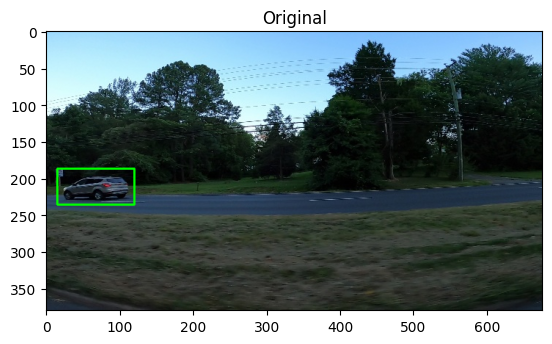

Границы: (60, 180, 124, 244), вероятность: 0.7953537097909105


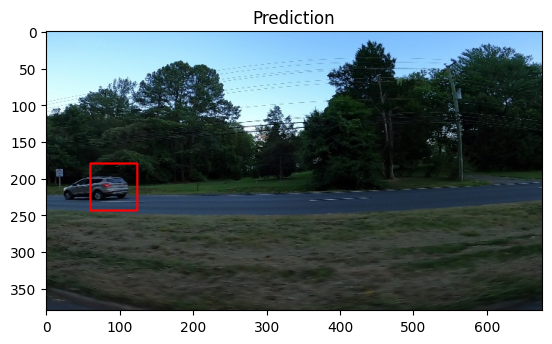

In [17]:
draw_res('car-object-detection/data/training_images/vid_4_10000.jpg')

Границы: [(331, 192, 429, 233)]


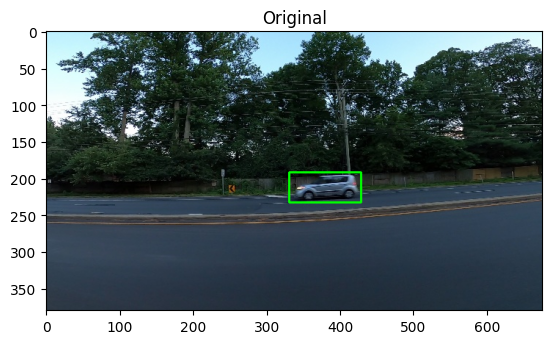

Границы: (336, 162, 432, 258), вероятность: 0.7648780773446736


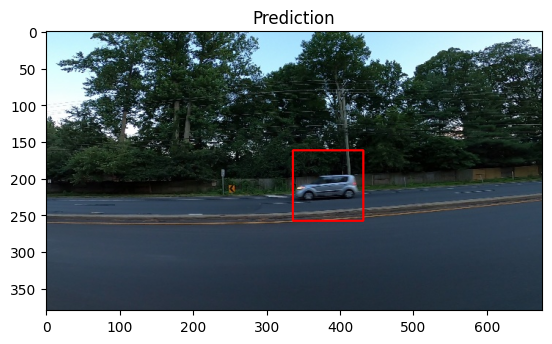

In [18]:
draw_res('car-object-detection/data/training_images/vid_4_11400.jpg')

## Выводы

При решении поставленной задачи метод со скользящим окном и HOG показал слабый результат, в то вреся как продвинутая модель (YOLOv8) продемонстрировала весьма неплохие значения метрик детектирования:

YOLOv8:\
mAP @ 0.5 = 0.9950\
mAP @ 0.75 = 0.9696\
mAP @ 0.5-0.95 = 0.8062 \

HOG:\
mAP @ 0.5: 0.2500 \
mAP @ 0.75: 0.1667 \
mAP @ 0.5:0.95: 0.1877 \